In [175]:
import pylab as pl
import numpy as np
import astropy.io.fits as fits
import matplotlib.pyplot as plt

from   specter.psf.gausshermite  import  GaussHermitePSF
from   lines import lines
from   desispec.io import read_frame, read_spectra
from   redrock.templates import find_templates, Template
from   astropy.table import Table
from   desispec.resolution import Resolution
from   desispec.interpolation import resample_flux

In [176]:
# Number of psf sigma to mask in the wavelength direction.
nsigma = 2.

In [177]:
# https://github.com/desihub/desispec/blob/294cfb66428aa8be3797fd046adbd0a2267c4409/py/desispec/sky.py#L1267
# Vaccum wavelengths [A]. 
skyline=np.array([5199.4,5578.4,5656.4,5891.4,5897.4,6302.4,6308.4,6365.4,6500.4,6546.4,\
                  6555.4,6618.4,6663.4,6679.4,6690.4,6765.4,6831.4,6836.4,6865.4,6925.4,\
                  6951.4,6980.4,7242.4,7247.4,7278.4,7286.4,7305.4,7318.4,7331.4,7343.4,\
                  7360.4,7371.4,7394.4,7404.4,7440.4,7526.4,7714.4,7719.4,7752.4,7762.4,\
                  7782.4,7796.4,7810.4,7823.4,7843.4,7855.4,7862.4,7873.4,7881.4,7892.4,\
                  7915.4,7923.4,7933.4,7951.4,7966.4,7982.4,7995.4,8016.4,8028.4,8064.4,\
                  8280.4,8284.4,8290.4,8298.4,8301.4,8313.4,8346.4,8355.4,8367.4,8384.4,\
                  8401.4,8417.4,8432.4,8454.4,8467.4,8495.4,8507.4,8627.4,8630.4,8634.4,\
                  8638.4,8652.4,8657.4,8662.4,8667.4,8672.4,8677.4,8683.4,8763.4,8770.4,\
                  8780.4,8793.4,8829.4,8835.4,8838.4,8852.4,8870.4,8888.4,8905.4,8922.4,\
                  8945.4,8960.4,8990.4,9003.4,9040.4,9052.4,9105.4,9227.4,9309.4,9315.4,\
                  9320.4,9326.4,9340.4,9378.4,9389.4,9404.4,9422.4,9442.4,9461.4,9479.4,\
                  9505.4,9521.4,9555.4,9570.4,9610.4,9623.4,9671.4,9684.4,9693.4,9702.4,\
                  9714.4,9722.4,9740.4,9748.4,9793.4,9802.4,9814.4,9820.4])

In [178]:
skyline.min(), skyline.max()

(5199.4, 9820.4)

In [179]:
# http://classic.sdss.org/dr6/algorithms/linestable.html: (3727.092, 3729.875)
lines.pprint(max_lines=-1, max_width=-1)

 LINEID      WAVELENGTH          NAME     REDSHIFT GROUP WIDTH GROUP FLUX GROUP SCALE FACTOR INDEX GROUP DOUBLET LINERATIO MASKED
-------- ------------------ ------------- -------------- ----------- ---------- ------------ ----- ----- ------- --------- ------
emlineid            1215.67      Ly_alpha          z_lya      w_ly_a      f1215          1.0     0     0     -99       0.0      0
emlineid            1240.81      N_V 1240      zemission       w_n_v      f1240          1.0     1     2     -99       0.0      0
emlineid            1549.48     C_IV 1549      zemission   wemission      f1549          1.0     2     3     -99       0.0      1
emlineid            1640.42    He_II 1640      zemission   wemission      f1640          1.0     3     3     -99       0.0      0
emlineid           1908.734   C_III] 1908      zemission   wemission      f1908          1.0     4     3     -99       0.0      0
emlineid  2800.315188621943    Mg_II 2799      zemission   wemission      f2799          1

In [180]:
bpsf = GaussHermitePSF('/global/homes/m/mjwilson/blanc/exposures/20201223/00069580/psf-b0-00069580.fits')
rpsf = GaussHermitePSF('/global/homes/m/mjwilson/blanc/exposures/20201223/00069580/psf-r0-00069580.fits')
zpsf = GaussHermitePSF('/global/homes/m/mjwilson/blanc/exposures/20201223/00069580/psf-z0-00069580.fits')

In [181]:
psfs = {'b': bpsf, 'r': rpsf, 'z': zpsf}

In [182]:
zs   = np.arange(0.0, 1.6, 1.e-6)
mask = np.zeros_like(zs)

In [183]:
wavea = 3727.0917225096655 * (1. + zs)
waveb = 3729.8754437612800 * (1. + zs)

In [184]:
wdisp = -99. * np.ones_like(wavea)

In [185]:
wavea.min(), wavea.max()

(3727.0917225096655, 9690.43847852513)

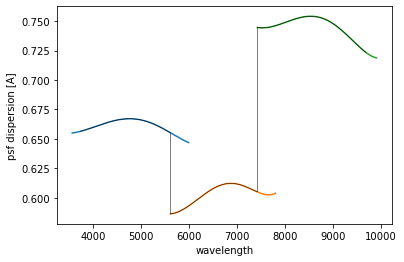

In [186]:
limits = {}

for x, cam in zip([bpsf, rpsf, zpsf], ['b', 'r', 'z']):
    limits[cam] = (x.wavelength()[250,:].min(), x.wavelength()[250,:].max())    
    
    isin = (wavea > limits[cam][0]) & (wavea < limits[cam][1])
    wdisp[isin] = x.wdisp(250, wavea[isin])
    
    pl.plot(x.wavelength()[250,:], x.wdisp(250, x.wavelength()[250,:]))
    
    pl.xlabel('wavelength')
    pl.ylabel('psf dispersion [A]')
    
pl.plot(wavea, wdisp, c='k', lw=0.5)

Text(0.5, 1.0, '2.00 * psf wavelength dispersion')

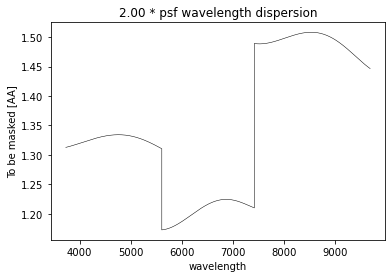

In [189]:
pl.plot(wavea, nsigma * wdisp, c='k', lw=0.5)
pl.xlabel('wavelength')
pl.ylabel('To be masked [AA]')
pl.title('{:.2f} * psf wavelength dispersion'.format(nsigma))

Text(0, 0.5, 'Mask half-width [A]')

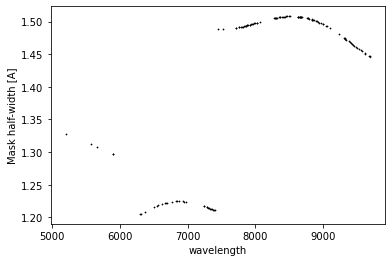

In [190]:
for line in skyline:
    for wave in [wavea, waveb]:
        if line<=wave[0] or line>=wave[-1]:
            continue
        
        # cam ordering takes the worst psf (to mask).
        for cam in ['z', 'b', 'r']:
            if (line > limits[cam][0]) & (line < limits[cam][1]):
                break
                
        hw = nsigma * psfs[cam].wdisp(250, line)
            
        pl.plot(line, hw, marker='.', markersize=1, c='k')
            
        ii=np.where((wave>=line-hw)&(wave<=line+hw))[0]

        mask[ii]=1.0
        
pl.xlabel('wavelength')
pl.ylabel('Mask half-width [A]')

In [191]:
np.mean(mask)

0.11513492804066998

In [192]:
mask = mask.astype(np.int)

In [193]:
np.mean(mask)

0.11513492804066998

In [194]:
to_write = Table()

In [195]:
to_write['REDSHIFT'] = zs

In [196]:
to_write['RADIAL_MASK'] = mask

In [197]:
to_write

REDSHIFT,RADIAL_MASK
float64,int64
0.0,0
1e-06,0
2e-06,0
3e-06,0
4e-06,0
4.9999999999999996e-06,0
6e-06,0
7e-06,0
8e-06,0


Text(0, 0.5, 'radial mask [1.4A half width]')

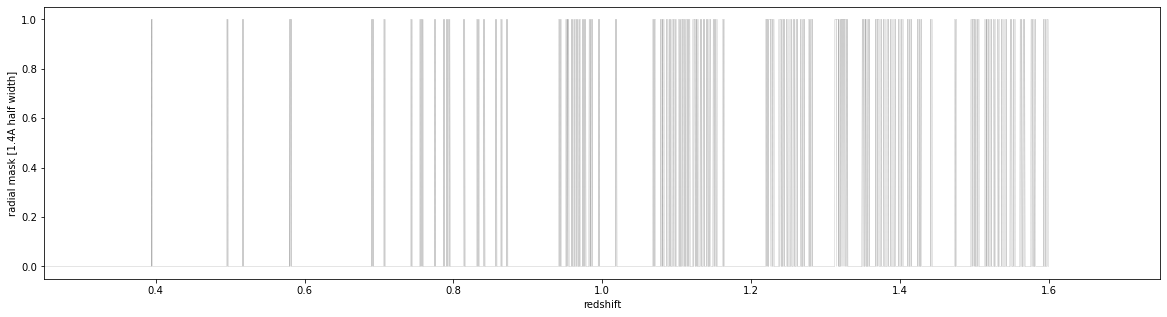

In [198]:
fig, ax = plt.subplots(1,1,figsize=(20,5))

ax.plot(to_write['REDSHIFT'], to_write['RADIAL_MASK'], c='k', lw=0.1)
ax.set_xlim(0.25, 1.75)

pl.xlabel('redshift')
pl.ylabel('radial mask [{:.1f}A half width]'.format(hw))

Text(0, 0.5, 'radial mask [1.4A half width]')

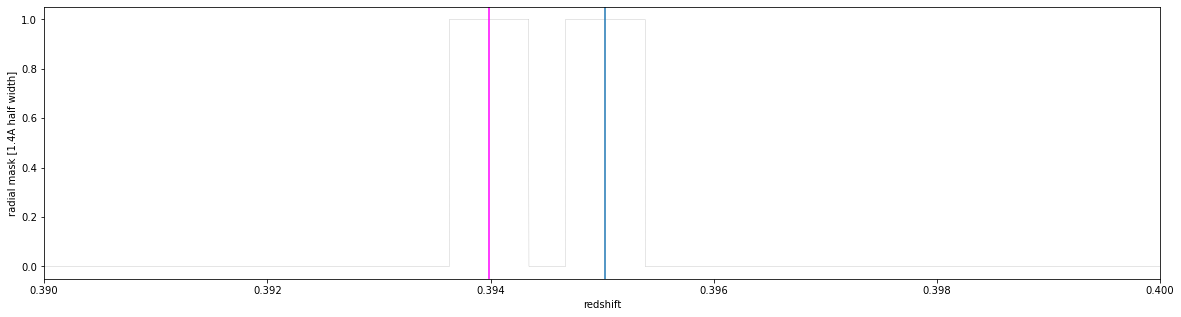

In [199]:
fig, ax = plt.subplots(1,1,figsize=(20,5))

ax.plot(to_write['REDSHIFT'], to_write['RADIAL_MASK'], c='k', lw=0.1)
ax.set_xlim(0.39, 0.40)

ax.axvline((5199.4/3727.0917225096655) - 1.)
ax.axvline((5199.4/3729.8754437612800) - 1., c='magenta')

pl.xlabel('redshift')
pl.ylabel('radial mask [{:.1f}A half width]'.format(hw))

Text(0, 0.5, 'radial mask [1.4A half width]')

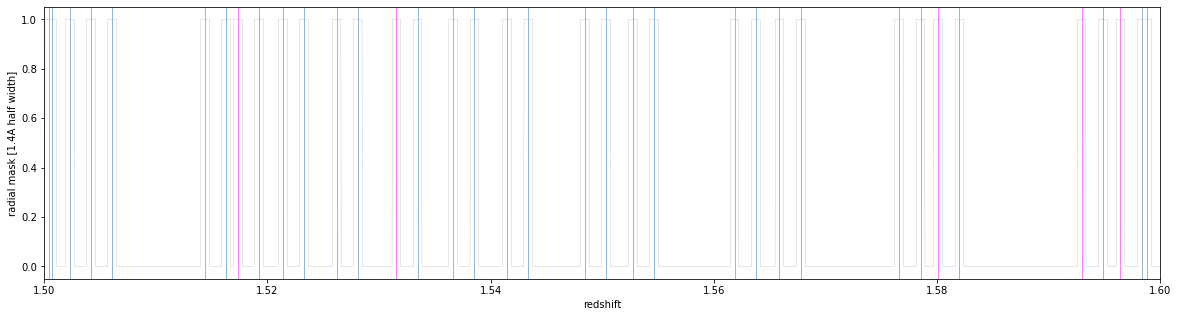

In [200]:
fig, ax = plt.subplots(1,1,figsize=(20,5))

ax.plot(to_write['REDSHIFT'], to_write['RADIAL_MASK'], c='k', lw=0.1)
ax.set_xlim(1.5, 1.6)

for line in skyline:
    ax.axvline((line/3727.0917225096655) - 1., lw=0.5)
    ax.axvline((line/3729.8754437612800) - 1., lw=0.5, c='magenta')

pl.xlabel('redshift')
pl.ylabel('radial mask [{:.1f}A half width]'.format(hw))

In [201]:
to_write.write('radial_mask.fits', format='fits', overwrite=True)

# Done.